In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [132]:
# Load data
df = pd.read_csv('weather_classification_data.csv')

In [133]:
# Split features and target
X = df.drop(['Weather Type'], axis=1)
y = df['Weather Type']

In [134]:
X_number = X.select_dtypes(include='number') 
X_categorical = X.select_dtypes(exclude='number')

### PCA

In [135]:
X_number.corr()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
Temperature,1.000000,-0.207969,-0.070022,-0.287206,0.209188,0.374773,0.250751
Humidity,-0.207969,1.000000,0.406079,0.638631,-0.120653,-0.342694,-0.479969
Wind Speed,-0.070022,0.406079,1.000000,0.443770,-0.077757,-0.068147,-0.311828
Precipitation (%),-0.287206,0.638631,0.443770,1.000000,-0.177444,-0.291601,-0.457444
Atmospheric Pressure,0.209188,-0.120653,-0.077757,-0.177444,1.000000,0.154128,0.120182
UV Index,0.374773,-0.342694,-0.068147,-0.291601,0.154128,1.000000,0.362922
Visibility (km),0.250751,-0.479969,-0.311828,-0.457444,0.120182,0.362922,1.000000


<Axes: xlabel='Humidity', ylabel='Precipitation (%)'>

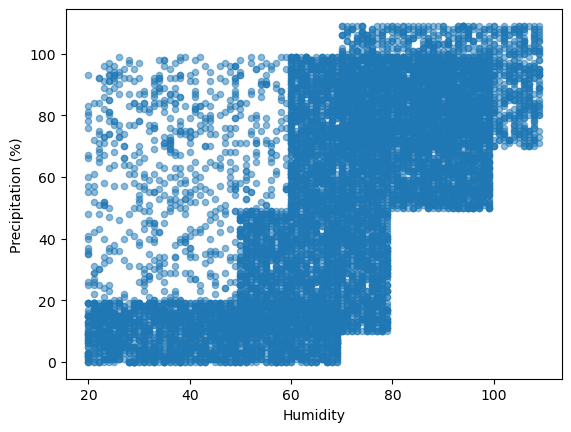

In [136]:
X.plot.scatter(x='Humidity',y='Precipitation (%)',alpha=0.5)

<Axes: xlabel='Humidity', ylabel='Precipitation (%)'>

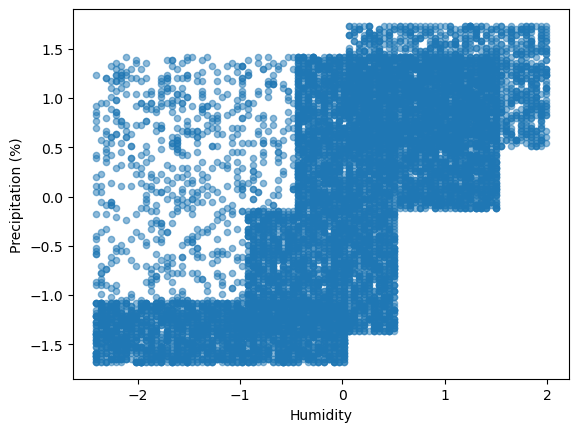

In [137]:
# standardize
X_number = (X_number - X_number.mean())/X_number.std()

X_number.plot.scatter(x='Humidity',y='Precipitation (%)',alpha=0.5)

In [138]:
n_comp = X_number.shape[1]
print('number of components',n_comp)

number of components 7


In [139]:
# create column names
cols = ['PC-'+str(i+1) for i in range(n_comp)]
cols

['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6', 'PC-7']

PC-1    0.40
PC-2    0.17
PC-3    0.13
PC-4    0.10
PC-5    0.08
PC-6    0.08
PC-7    0.05
dtype: float64


<Axes: title={'center': 'PVE'}>

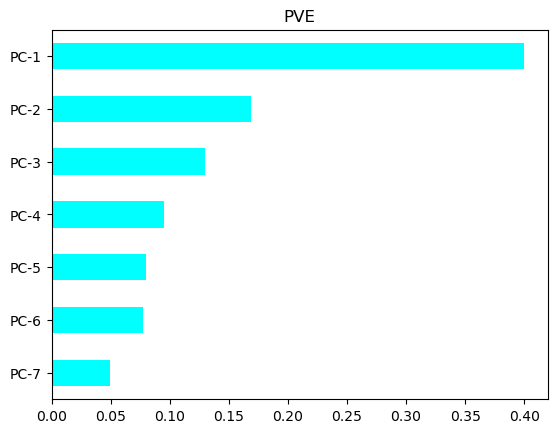

In [140]:
# compute principal components and PVE
pca = PCA(n_components=n_comp)
pca.fit(X_number)
PVE = pca.explained_variance_ratio_
PVE = pd.Series(PVE,index=cols)
print(PVE.round(2))
PVE.sort_values().plot.barh(color='cyan',title='PVE')

In [141]:
sd = np.sqrt(pca.explained_variance_)
sd

array([1.67315509, 1.08764568, 0.95188905, 0.81737714, 0.74737482,
       0.73585914, 0.58593768])

In [142]:
total = 0
count = 0
for val in PVE.sort_values(ascending=False):
    total += val
    count += 1
    print(count, total)

1 0.3999211385525845
2 0.5689172990352395
3 0.6983591216383142
4 0.7938027484364807
5 0.8735983367944343
6 0.9509538616826162
7 1.0


For this project, we will use 4 components to capture 79% of the variability, reducing our total numberical feature count by 3.

In [143]:
n_comp = 4
print('number of components',n_comp)

number of components 4


In [144]:
# create column names
cols = ['PC-'+str(i+1) for i in range(n_comp)]
cols

['PC-1', 'PC-2', 'PC-3', 'PC-4']

PC-1    0.40
PC-2    0.17
PC-3    0.13
PC-4    0.10
dtype: float64


<Axes: title={'center': 'PVE'}>

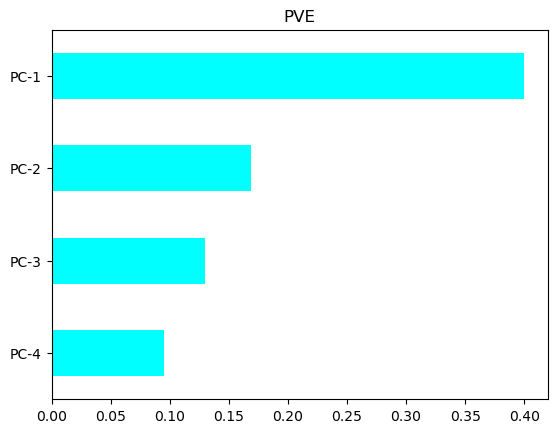

In [145]:
# compute principal components and PVE
pca = PCA(n_components=n_comp)
pca.fit(X_number)
PVE = pca.explained_variance_ratio_
PVE = pd.Series(PVE,index=cols)
print(PVE.round(2))
PVE.sort_values().plot.barh(color='cyan',title='PVE')

In [146]:
PVE.sum()

np.float64(0.7938027484364807)

In [147]:
L = pca.components_
L = pd.DataFrame(L,index=cols,columns=X_number.columns)
print(L.shape)
L.round(2)

(4, 7)


,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
PC-1,-0.30,0.47,0.33,0.48,-0.19,-0.35,-0.43
PC-2,0.54,0.22,0.51,0.19,0.41,0.44,-0.05
PC-3,-0.11,0.07,-0.26,-0.07,0.85,-0.38,-0.20
PC-4,0.74,0.16,-0.35,-0.10,-0.27,-0.33,-0.34


In [148]:
# transformed features
Z = pca.transform(X_number)
Z = pd.DataFrame(Z,columns=cols)
print(Z.shape)
Z.head(3).round(2)

(13200, 4)


,PC-1,PC-2,PC-3,PC-4
0,1.01,-0.11,0.42,0.08
1,-0.38,1.26,-0.45,0.31
2,-1.16,0.11,0.30,0.51


(-3.0, 3.0)

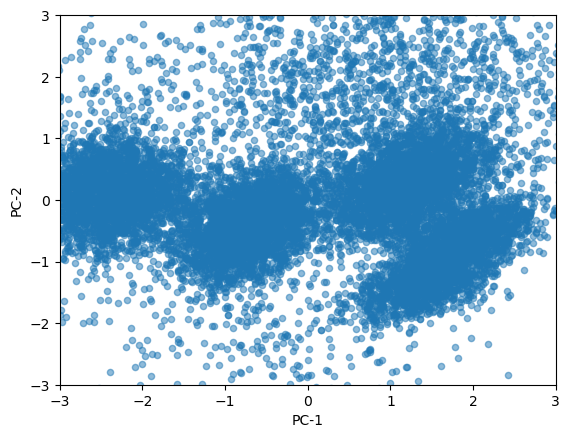

In [149]:
Z.plot.scatter(x='PC-1',y='PC-2',alpha=0.5)
plt.xlim([-3,3])
plt.ylim([-3,3])

In [150]:
X = pd.concat([Z, X_categorical], axis=1)
X.head(3)

,PC-1,PC-2,PC-3,PC-4,Cloud Cover,Season,Location
0,1.007496,-0.109852,0.424049,0.077334,partly cloudy,Winter,inland
1,-0.379703,1.263428,-0.450281,0.306982,partly cloudy,Spring,inland
2,-1.162129,0.106226,0.301883,0.509846,clear,Spring,mountain


In [151]:
X_number = X.select_dtypes(include='number') 
X_categorical = X.select_dtypes(exclude='number')

### Training

In [152]:
# Identify column types
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()

In [153]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}

In [154]:
# Baseline Model
mode_class = y_train.mode()[0]
baseline_pred = [mode_class] * len(y_test)
baseline_acc = accuracy_score(y_test, baseline_pred)
results['Baseline'] = baseline_acc
print(f"Baseline Accuracy: {baseline_acc:.2f}")

Baseline Accuracy: 0.24


In [155]:
# KNN Model (with preprocessing)
knn_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
knn_pipe = Pipeline([
    ('preprocessor', knn_preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
knn_pipe.fit(X_train, y_train)
knn_acc = knn_pipe.score(X_test, y_test)
results['KNN'] = knn_acc
print(f"KNN Accuracy: {knn_acc:.2f}")


KNN Accuracy: 0.88


In [156]:
# Random Forest Model (with preprocessing)
rf_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
rf_pipe = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42))
])
rf_pipe.fit(X_train, y_train)
rf_acc = rf_pipe.score(X_test, y_test)
results['Random Forest'] = rf_acc
print(f"Random Forest Accuracy: {rf_acc:.2f}")

Random Forest Accuracy: 0.89


In [157]:
# SVM Model (with preprocessing and grid search)
svm_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])
svm_pipe = Pipeline([
    ('preprocessor', svm_preprocessor),
    ('svm', SVC())
])
svm_param_grid = {
    'svm__C': [6.5],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale']
}
svm_grid = GridSearchCV(svm_pipe, svm_param_grid, cv=3, n_jobs=-1)
svm_grid.fit(X_train, y_train)
svm_acc = svm_grid.score(X_test, y_test)
results['SVM'] = svm_acc
print(f"SVM Accuracy: {svm_acc:.2f}")

SVM Accuracy: 0.89


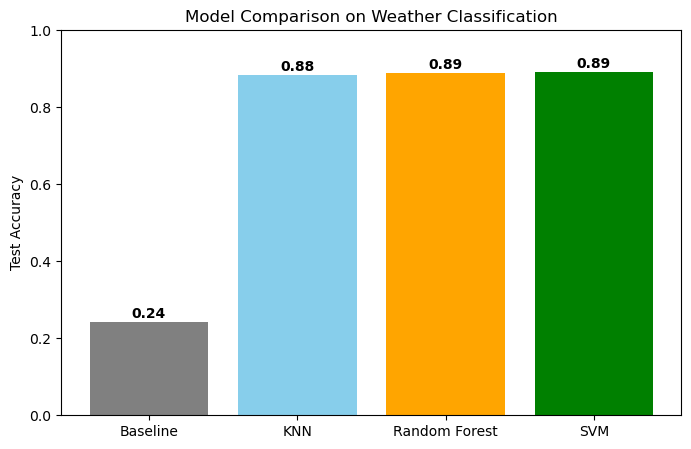

In [158]:
# Bar chart of results
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['gray', 'skyblue', 'orange', 'green'])
plt.ylabel('Test Accuracy')
plt.title('Model Comparison on Weather Classification')
plt.ylim(0, 1)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

In [191]:
print(y_test.value_counts())

Weather Type
Snowy     701
Cloudy    651
Rainy     647
Sunny     641
Name: count, dtype: int64


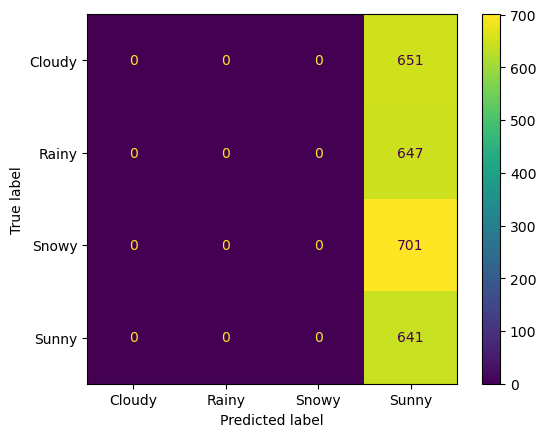

In [198]:
cm = confusion_matrix(y_test, baseline_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cloudy', 'Rainy','Snowy','Sunny'])
disp.plot()

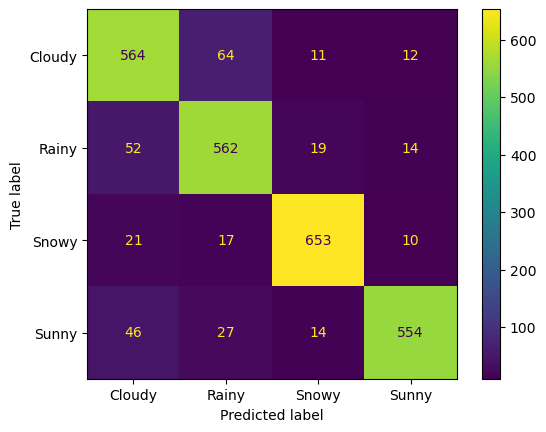

In [199]:
cm = confusion_matrix(y_test, knn_pipe.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cloudy', 'Rainy','Snowy','Sunny'])
disp.plot()

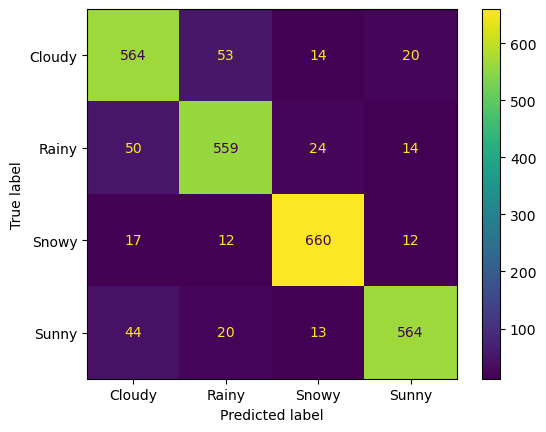

In [200]:
cm = confusion_matrix(y_test, rf_pipe.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cloudy', 'Rainy','Snowy','Sunny'])
disp.plot()

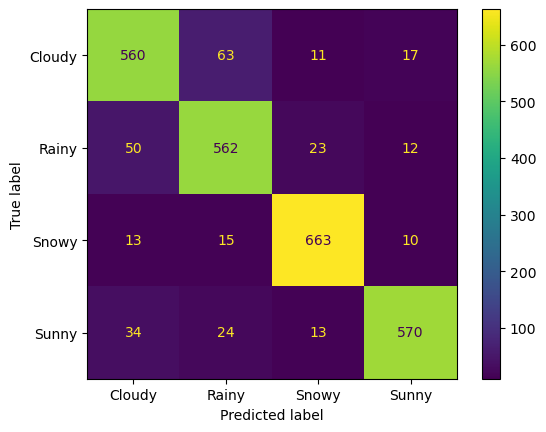

In [201]:
cm = confusion_matrix(y_test, svm_grid.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cloudy', 'Rainy','Snowy','Sunny'])
disp.plot()

## Live dataset results

In [159]:
df = pd.read_csv('live_weather_classification_data.csv')
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,27.777778,79,4.62,0,partly cloudy,1014,0.0000,Spring,10.0,coastal,Cloudy
1,27.777778,77,4.32,0,partly cloudy,1014,0.3033,Spring,10.0,coastal,Sunny
2,27.222222,74,4.20,0,partly cloudy,1014,1.3210,Spring,10.0,coastal,Sunny
3,26.666667,72,3.95,0,partly cloudy,1015,3.2487,Spring,10.0,coastal,Sunny
4,25.555556,76,4.01,0,clear,1014,6.0570,Spring,10.0,coastal,Sunny


In [160]:
# Split features and target
X = df.drop(['Weather Type'], axis=1)
y = df['Weather Type']



In [161]:
X_number = X.select_dtypes(include='number') 
X_categorical = X.select_dtypes(exclude='number')

In [162]:
# standardize
X_number = (X_number - X_number.mean())/X_number.std()

In [163]:
X_number.head(3)

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
0,1.432118,0.579027,1.555986,-0.691101,1.104303,-1.107306,NaN
1,1.432118,0.508745,1.312777,-0.691101,1.104303,-1.017543,NaN
2,1.319795,0.403323,1.215493,-0.691101,1.104303,-0.716353,NaN


In [164]:
print('visibility min:', df['Visibility (km)'].min())
print('visibility max:', df['Visibility (km)'].max())

visibility min: 10.0
visibility max: 10.0


The standardized visiblity values are NaN because all original visibility values were 10 km, leading to a standard deviation of 0. We will set the standardized visiblity column to 0 to signify that all values are the same.

In [165]:
X_number['Visibility (km)'] = 0

In [166]:
# transformed features
Z = pca.transform(X_number)
Z = pd.DataFrame(Z,columns=cols)
print(Z.shape)
Z.head(3).round(2)

(44, 4)


,PC-1,PC-2,PC-3,PC-4
0,0.21,1.53,0.89,0.74
1,0.06,1.43,0.92,0.78
2,-0.09,1.43,0.83,0.62


In [167]:
X = pd.concat([Z, X_categorical], axis=1)
X.head(3)

,PC-1,PC-2,PC-3,PC-4,Cloud Cover,Season,Location
0,0.209598,1.526891,0.892279,0.738253,partly cloudy,Spring,coastal
1,0.063969,1.427231,0.917001,0.783440,partly cloudy,Spring,coastal
2,-0.089331,1.425440,0.831935,0.619164,partly cloudy,Spring,coastal


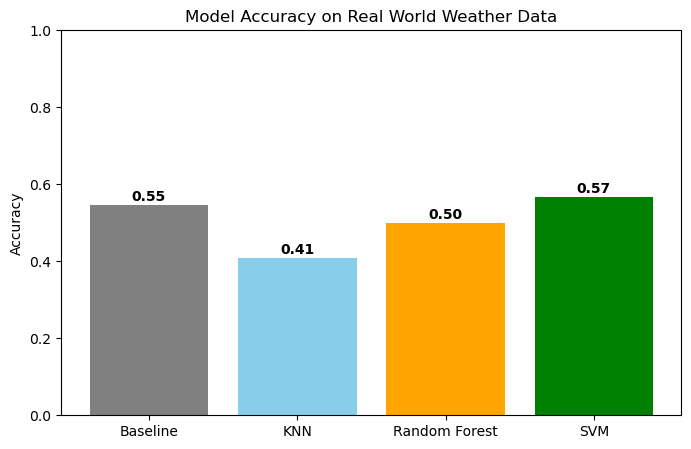

In [168]:
from sklearn.metrics import accuracy_score

# Baseline Model
mode_class_real = y.mode()[0]
baseline_pred_real = [mode_class_real] * len(y)


# Apply trained models to the real world data in X
knn_pred_real = knn_pipe.predict(X)
rf_pred_real = rf_pipe.predict(X)
# Predict with SVM
svm_pred_real = svm_grid.predict(X)

# Calculate accuracy for each model
baseline_acc_real = accuracy_score(y, baseline_pred_real)
knn_acc_real = accuracy_score(y, knn_pred_real)
rf_acc_real = accuracy_score(y, rf_pred_real)
svm_acc_real = accuracy_score(y, svm_pred_real)

# Show bar chart
model_names = ['Baseline', 'KNN', 'Random Forest', 'SVM']
accuracies = [baseline_acc_real, knn_acc_real, rf_acc_real, svm_acc_real]
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['gray', 'skyblue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Real World Weather Data')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

In [169]:
print(X.head(3))
print()
print(y.head(3))

       PC-1      PC-2      PC-3      PC-4    Cloud Cover  Season Location
0  0.209598  1.526891  0.892279  0.738253  partly cloudy  Spring  coastal
1  0.063969  1.427231  0.917001  0.783440  partly cloudy  Spring  coastal
2 -0.089331  1.425440  0.831935  0.619164  partly cloudy  Spring  coastal

0    Cloudy
1     Sunny
2     Sunny
Name: Weather Type, dtype: object


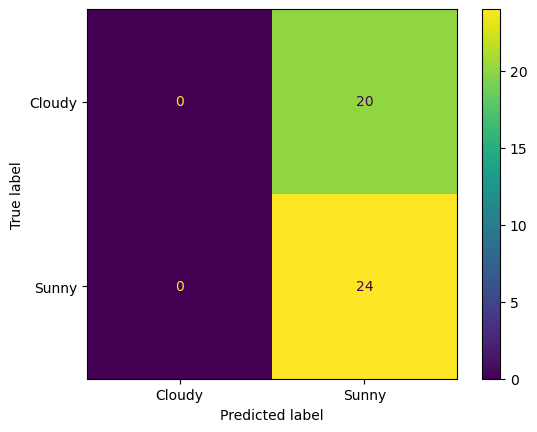

In [185]:
cm = confusion_matrix(y, baseline_pred_real)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cloudy', 'Sunny'])
disp.plot()

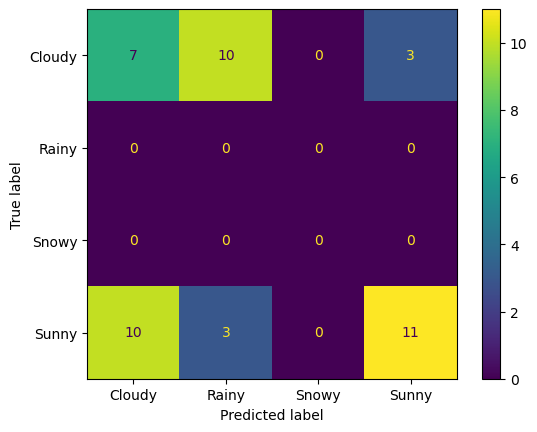

In [182]:
labels = knn_pipe.classes_
cm = confusion_matrix(y, knn_pred_real, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

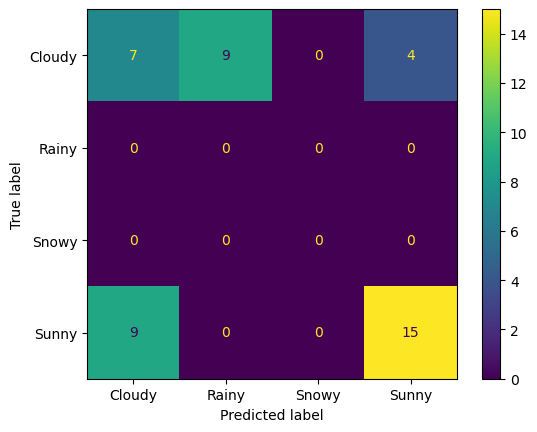

In [181]:
labels = rf_pipe.classes_
cm = confusion_matrix(y, rf_pred_real, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

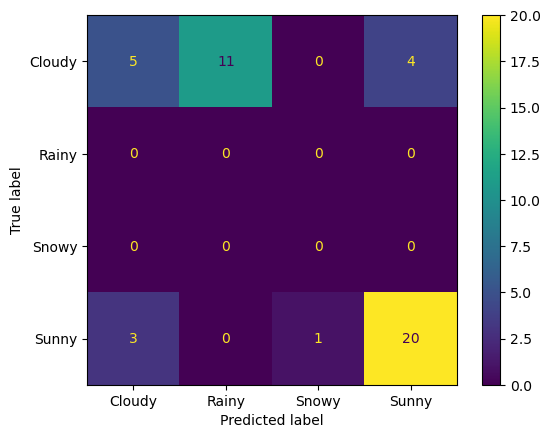

In [180]:
labels = svm_grid.classes_
cm = confusion_matrix(y, svm_pred_real, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()